In [1]:
import pandas as pd
import numpy as np
import tcrdist
import tcrdist.repertoire

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import itertools
import os
import pathlib
import subprocess
import io
import re

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
from IPython.display import display, HTML
display(HTML("""
<style>
.lm-Widget {overflow-x: scroll !important;}
</style>
"""))

In [4]:
pd.options.display.max_columns = 200

In [5]:
pd.options.display.max_rows = 200

In [6]:
all_hlas = pd.read_csv('../analysis/mira_postgliph_hla_cd4_all.csv', index_col=0)

In [7]:
all_hlas.Patient.nunique()

19

In [8]:
for column in all_hlas.columns:
    if pd.api.types.is_object_dtype(all_hlas[column]):
        all_hlas[column] = all_hlas[column].str.replace('!', '')

In [9]:
mira = pd.read_csv('../analysis/mira_postgliph_cd4_2.csv', index_col=0)

In [10]:
mira['cell.type'].unique()

array(['CD4'], dtype=object)

In [ ]:
all_hlas

# Prepare HLAs

1. For each allele: `DP, DQ, DR` put as many rows as needed for each patient
2. Each allele for `DP` is a combo of `DPA` and `DPB` separated by `/`
3. Each allele for `DQ` is a combo if `DQA` and `DQB` separated by `/`
4. Each allele for `DR` is one item of `DRB1/3/4/5`

In [13]:
all_hlas = all_hlas.replace('-', '')

In [14]:
all_hlas['hla_dpa'] = all_hlas['HLA-DPA1'].str.split('/')

In [15]:
all_hlas['hla_dpb'] = all_hlas['HLA-DPB1'].str.split('/')

In [16]:
def hla_dp(row):
    if len(row.hla_dpa) == 0 or len(row.hla_dpb) == 0:
        return np.nan
    if row.hla_dpa == [''] or row.hla_dpb == ['']:
        return np.nan
    return [
        f'{a}/{b}'
        for a, b in itertools.product(row.hla_dpa, row.hla_dpb)
    ]
all_hlas['hla_dp'] = all_hlas.apply(hla_dp, axis=1)

In [17]:
hla_dp = all_hlas.explode('hla_dp')

In [18]:
all_hlas['hla_dqa'] = all_hlas['HLA-DQA1'].str.split('/')

In [19]:
all_hlas['hla_dqb'] = all_hlas['HLA-DQB1'].str.split('/')

In [20]:
def hla_dq(row):
    if len(row.hla_dqa) == 0 or len(row.hla_dqb) == 0:
        return np.nan
    if row.hla_dqa == [''] or row.hla_dqb == ['']:
        return np.nan
    return [
        f'{a}/{b}'
        for a, b in itertools.product(row.hla_dqa, row.hla_dqb)
    ]
all_hlas['hla_dq'] = all_hlas.apply(hla_dq, axis=1)

In [21]:
hla_dq = all_hlas.explode('hla_dq')

In [22]:
all_hlas['hla_drb1'] = all_hlas['HLA-DRB1'].str.split('/')
all_hlas['hla_drb3'] = all_hlas['HLA-DRB3'].str.split('/')
all_hlas['hla_drb4'] = all_hlas['HLA-DRB4'].str.split('/')
all_hlas['hla_drb5'] = all_hlas['HLA-DRB5'].str.split('/')

In [23]:
def hla_dr(row):
    return [
        x
        for x in itertools.chain(row.hla_drb1, row.hla_drb3, row.hla_drb4, row.hla_drb5)
        if x != ''
    ]
all_hlas['hla_dr'] = all_hlas.apply(hla_dr, axis=1)

In [24]:
hla_dr = all_hlas.explode('hla_dr')

# IEDB HLA binding affinity

In [25]:
IEDB_QUERY = pathlib.Path('03_iedb_query_mhc2')

In [26]:
os.makedirs(IEDB_QUERY, exist_ok=True)

In [27]:
hla_info = hla_dp.groupby('Patient').agg({
    'hla_dp': tuple,
}).reset_index()

In [28]:
mira_hla = mira.merge(hla_info, left_on='study_id', right_on='Patient', how='left')

In [29]:
all_epitopes = pd.Series(pd.Series(itertools.chain(*mira_hla.Amino_Acids.str.split(','))).unique())

In [30]:
def generate_fastq(epitopes):
    epitope_fastq = ''
    for epitope in epitopes:
        epitope_fastq += f'> {epitope}\n{epitope}\n\n'
    return epitope_fastq

In [31]:
epitope_fastqs = all_epitopes.groupby(all_epitopes.str.len()).apply(generate_fastq)

In [32]:
for length, fastq in epitope_fastqs.items():
    with open(IEDB_QUERY / f'epitopes_{length}.fasta', 'w') as f:
        f.write(fastq)

In [33]:
IEDB_TOOL = '/projects/p31980/MoralesNebreda_Lab/tools/mhc_ii/mhc_II_binding.py'

In [34]:
ALL_BAD_ALLELES = {}

In [35]:
ALL_RESULTS = {}

## 1. DP

In [37]:
unique_hlas = pd.Series(hla_dp.hla_dp.dropna().unique())

In [38]:
%%time
bad_alleles = []
CACHE = IEDB_QUERY / 'hla_dp_results.csv'
if CACHE.exists():
    iedb_results = pd.read_csv(CACHE, index_col=0)
else:
    iedb_results = []
    for length in epitope_fastqs.index:
        for _ in range(2):
            command = [
                'python3',
                IEDB_TOOL,
                'netmhciipan_el',
                ','.join(unique_hlas),
                str(IEDB_QUERY / f'epitopes_{length}.fasta'),
                ','.join([str(length)] * unique_hlas.size)
            ]
            result = subprocess.run(command, capture_output=True)
            if result.returncode == 1:
                if result.stderr.decode().startswith('Invalid allele'):
                    bad_alleles = re.search(r'Invalid allele name "([^"]+)"', result.stderr.decode())
                    bad_alleles = re.split(r',\s+', bad_alleles.group(1))
                    unique_hlas = pd.Series(list(set(unique_hlas) - set(bad_alleles)))
                else:
                    raise ValueError(result.stderr)
        iedb_results.append(pd.read_table(io.StringIO(result.stdout.decode())))
    iedb_results = pd.concat(iedb_results)
    iedb_results.reset_index(drop=True, inplace=True)
    iedb_results.to_csv(CACHE)

CPU times: user 7.49 ms, sys: 6.95 ms, total: 14.4 ms
Wall time: 71.1 ms


In [39]:
ALL_BAD_ALLELES['dp'] = bad_alleles

In [40]:
ALL_RESULTS['dp'] = iedb_results

## 1. DQ

In [41]:
unique_hlas = pd.Series(hla_dq.hla_dq.dropna().unique())

In [42]:
%%time
bad_alleles = []
CACHE = IEDB_QUERY / 'hla_dq_results.csv'
if CACHE.exists():
    iedb_results = pd.read_csv(CACHE, index_col=0)
else:
    iedb_results = []
    for length in epitope_fastqs.index:
        for _ in range(2):
            command = [
                'python3',
                IEDB_TOOL,
                'netmhciipan_el',
                ','.join(unique_hlas),
                str(IEDB_QUERY / f'epitopes_{length}.fasta'),
                ','.join([str(length)] * unique_hlas.size)
            ]
            result = subprocess.run(command, capture_output=True)
            if result.returncode == 1:
                if result.stderr.decode().startswith('Invalid allele'):
                    bad_alleles = re.search(r'Invalid allele name "([^"]+)"', result.stderr.decode())
                    bad_alleles = re.split(r',\s+', bad_alleles.group(1))
                    unique_hlas = pd.Series(list(set(unique_hlas) - set(bad_alleles)))
                else:
                    raise ValueError(result.stderr)
        iedb_results.append(pd.read_table(io.StringIO(result.stdout.decode())))
    iedb_results = pd.concat(iedb_results)
    iedb_results.reset_index(drop=True, inplace=True)
    iedb_results.to_csv(CACHE)

CPU times: user 5.88 ms, sys: 2.07 ms, total: 7.96 ms
Wall time: 20 ms


In [43]:
ALL_BAD_ALLELES['dq'] = bad_alleles

In [44]:
ALL_RESULTS['dq'] = iedb_results

## 1. DR

In [45]:
unique_hlas = pd.Series(hla_dr.hla_dr.dropna().unique())

In [46]:
%%time
bad_alleles = []
CACHE = IEDB_QUERY / 'hla_dr_results.csv'
if CACHE.exists():
    iedb_results = pd.read_csv(CACHE, index_col=0)
else:
    iedb_results = []
    for length in epitope_fastqs.index:
        for _ in range(2):
            command = [
                'python3',
                IEDB_TOOL,
                'netmhciipan_el',
                ','.join(unique_hlas),
                str(IEDB_QUERY / f'epitopes_{length}.fasta'),
                ','.join([str(length)] * unique_hlas.size)
            ]
            result = subprocess.run(command, capture_output=True)
            if result.returncode == 1:
                if result.stderr.decode().startswith('Invalid allele'):
                    bad_alleles = re.search(r'Invalid allele name "([^"]+)"', result.stderr.decode())
                    bad_alleles = re.split(r',\s+', bad_alleles.group(1))
                    unique_hlas = pd.Series(list(set(unique_hlas) - set(bad_alleles)))
                else:
                    raise ValueError(result.stderr)
        iedb_results.append(pd.read_table(io.StringIO(result.stdout.decode())))
    iedb_results = pd.concat(iedb_results)
    iedb_results.reset_index(drop=True, inplace=True)
    iedb_results.to_csv(CACHE)

CPU times: user 9.62 ms, sys: 3.6 ms, total: 13.2 ms
Wall time: 54.5 ms


In [47]:
ALL_BAD_ALLELES['dr'] = bad_alleles

In [48]:
ALL_RESULTS['dr'] = iedb_results

In [49]:
iedb_results = pd.concat(ALL_RESULTS.values())
iedb_results.allele = iedb_results.allele.str.replace('HLA-', '')
iedb_results = iedb_results.set_index(['allele', 'peptide'])

## TODO

1. for each row in mira
2. for each epitope in the row
3. find best (smallest) rank score for all allele
4. report best rank score among epitopes for row

In [50]:
iedb_mira_index = mira.Amino_Acids.apply(
    lambda x: pd.Series(x.split(','))
).reset_index(names='id').melt(
    id_vars='id',
    value_name='epitope'
).dropna()

In [51]:
iedb_mira_index = iedb_mira_index.merge(mira[['study_id']], left_on='id', right_index=True)

In [52]:
iedb_mira_index = iedb_mira_index.merge(all_hlas[
    ['Patient', 'hla_dp', 'hla_dq', 'hla_dr']
], left_on='study_id', right_on='Patient')

In [53]:
iedb_mira_index = iedb_mira_index.melt(
    id_vars=['id', 'epitope', 'study_id'],
    value_vars=['hla_dp', 'hla_dq', 'hla_dr'],
    value_name='allele'
)

In [56]:
iedb_mira_index = iedb_mira_index.dropna()

In [57]:
iedb_mira_index = iedb_mira_index.explode('allele')

In [59]:
iedb_mira_index = iedb_mira_index.dropna()

In [61]:
iedb_mira_index = iedb_mira_index.groupby('id').apply(
    lambda x: x.drop_duplicates(),
    include_groups=False
).reset_index(names=['id', '_'])

In [63]:
mira.index[~mira.index.isin(iedb_mira_index.id)]

Index([70], dtype='int64')

In [64]:
iedb_mira_index.shape

(5125, 6)

In [65]:
index_values = pd.MultiIndex.from_tuples(
    iedb_mira_index.apply(lambda r: (r.allele, r.epitope), axis=1).values
)

In [66]:
index_selection = index_values.isin(iedb_results.index)

In [67]:
iedb_mira_index.loc[index_selection, 'binding_rank'] = iedb_results['percentile_rank'].loc[
    index_values[index_selection]
].values

In [68]:
iedb_mira_index = iedb_mira_index.dropna()

In [69]:
iedb_affinity = iedb_mira_index.sort_values(['id', 'binding_rank']).groupby('id').head(1).set_index('id')

In [70]:
idx = mira.index.isin(iedb_affinity.index)
mira.loc[idx, 'binding_rank'] = iedb_affinity.binding_rank[mira.index[idx]]

In [71]:
mira.binding_rank.isna().sum()

1

In [72]:
mira.shape

(232, 52)

In [73]:
mira.binding_rank.lt(1).sum()

5

<Axes: ylabel='Frequency'>

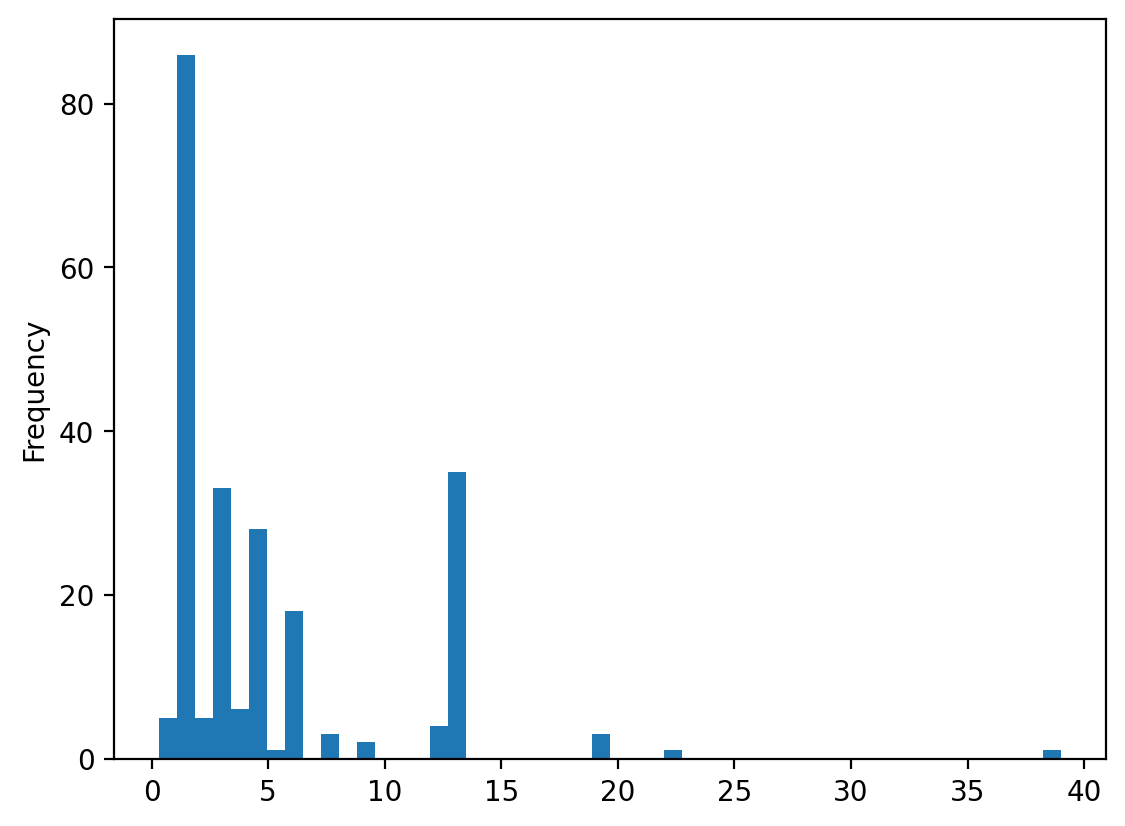

In [74]:
mira.binding_rank.plot.hist(bins=50)

In [75]:
mira.binding_rank.ge(5).sum()

68

In [ ]:
mira

## JOIN Pgen

In [77]:
pgens = pd.read_csv('../analysis/cd4_post_gliph_tcr_with_pgen.csv', index_col=0)

In [78]:
pgens[['cdr3_b_aa', 'pgen_log10']].drop_duplicates()

,cdr3_b_aa,pgen_log10
0,CASSQDTTETQYF,-7.665391
1,CASSLGGQETQYF,-5.676527
2,CASSLGLGNTIYF,-6.742806
3,CASSLSQSYEQYF,-7.015595
4,CASSYRQGHGYTF,-7.503169
...,...,...
1774,CAWSRQEDSPLHF,-9.574159
1775,CASSLPGFSPLHF,-7.780530
1776,CASSLPGFSPLHY,NaN
1777,CASSKQREAFF,-7.980961


In [79]:
pgens.cdr3_b_aa.nunique()

1252

In [80]:
tcr_to_pgen = pgens[['cdr3_b_aa', 'pgen_log10']].drop_duplicates().set_index('cdr3_b_aa').pgen_log10

In [81]:
mira['pgen_log10'] = tcr_to_pgen[mira.TCR].values

## SAVE

In [82]:
mira.to_csv(
    '../analysis/cd4_mira_iedb_pgen_all.csv'
)